# Test learning capacity
In this notebook we will test whether the generator structure can actually learn. Use a simple example from Pytorch.
See [source](https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe).


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import threading
import logging
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

import matplotlib.pyplot as plt
from os import system

In [4]:
dims = 4
samples = 500
X1 = torch.randn(samples, dims)
X2 = torch.randn(samples, dims) + 3
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(samples, 1)
Y2 = torch.ones(samples, 1)
Y = torch.cat([Y1, Y2], dim=0)

print(X.size())
print(Y.size())

torch.Size([1000, 4])
torch.Size([1000, 1])


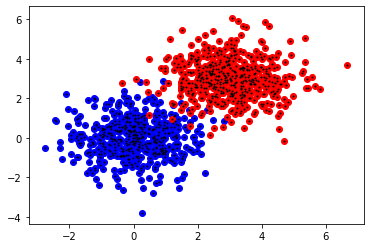

In [5]:

plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='r')
plt.scatter(X[:, 0], X[:, 1], color='k', s=1);

In [6]:
import Generator as gen

In [5]:
class FTT_Layer(torch.nn.Module):
    def __init__(self, N, rank, imwidth, imheight, verbose = 0):
        super(FTT_Layer, self).__init__()

        # N = order of the polynomial = order of the tensor A:
        # A is of dimension (s, s, ..., s) = (N x s)
        # rank = rank used for the tensor cores
        # size = length of the flattened input
        self.N = N
        self.rank = rank
        self.s = imwidth * imheight
        self.verbose = verbose
        self.lock = threading.Lock()

        # Make a list of TTcore ranks, starting from r_0 = r_N = 1: perhaps feed it in as a list? isinstance(rank, list)
        self.ranklist = [1, 1]
        for n in range(self.N - 1):
            self.ranklist.insert(-1, self.rank)

        # Start by making the tensor train: store the matrices in one big parameterlist
        self.TT = torch.nn.ParameterList()

        # Make s instances for every mode of the tensor, or make a 3D tensor instead:
        for n in range(self.N):
            # Make tensors of size (r_{k-1}, n_{k} = self.s, r_{k})
            TTcore = torch.empty(self.ranklist[n], self.s, self.ranklist[n+1])
            torch.nn.init.xavier_normal_(TTcore)
            TTcore /= self.s
            self.TT.append(torch.nn.Parameter(TTcore))

        if self.verbose != 0:
            print("self.ranklist =", self.ranklist)
            print("self.N =", self.N, "+ 1 ?=", len(self.ranklist), "= len(self.ranklist)")
            print("TT has", len(self.TT), "elements:")
            for i, tt in enumerate(self.TT):
                print("element", i, ":", tt.shape)

    def test(self):
        # The multiplication z_i * G_k(i) is really [1] * [rank, rank] (or for last cart [1] * [rank, 1] )
        # Here we test whether the vectorized multiplication yields the same result. Warning: this is slow!
        k = 1
        # According to the algorithm:
        summation = 0
        for i in range(self.s):
            summation += self.z[i] * self.TT[k][:,i,:]

        # Naive fast implmentation is: self.V[k] = self.z @ self.TT[k]. Does not yield same results.
        # Instead, permute the axes of the train cart from [rank, s, rank] to [s, rank**2] (or [s, rank*1])
        perm = self.TT[k].permute(1,0,2).reshape(self.s,-1)
        product = torch.matmul(self.z, perm).reshape(self.ranklist[k], self.ranklist[k+1])

        # Assert whether they are the same:
        print("Are the two methods equivalent?", torch.allclose(summation, product, rtol = 1e-03, atol = 1e-03))
        return

    def parallelVecProd(self, k):
        d1, d2 = self.ranklist[k], self.ranklist[k+1]
        cop = self.TT[k].clone()
        tmp = torch.matmul(self.z, cop.permute(1,0,2).reshape(self.s, d1*d2))
        #self.V[k,0:d1,0:d2] = tmp.reshape(d1, d2)
        ####self.V[k] = tmp.reshape(d1, d2)
        #with self.lock:
        #    print('before: shape =', self.V[k,0:d1,0:d2].shape, 'version = ', self.V[k,0:d1,0:d2]._version)

        with torch.no_grad():
            self.V[k,0:d1,0:d2] = tmp.reshape(d1, d2)
        #with self.lock:    
        #    print('after: shape =', self.V[k,0:d1,0:d2].shape, 'version = ', self.V[k,0:d1,0:d2]._version)

        return

    def forward(self, z):
        # Compute the forward pass: the nmode multiplications f = A x1 z x2 z x3 ··· x(N-1) z
        # Follow algorithm 1: allocate space and compute each V^(k), possible in parallel with threads.
        # V^(0) will not be used as it is unnecessary to compute it, it's just self.TT[0][0,:,:]
        self.V = torch.empty(self.N, self.rank, self.rank) #[None] * self.N
        #self.V = [None] * self.N
        self.z = z
        threads = []

        if self.verbose != 0:
            print("Threads are computing..")
            self.test()

        for k in range(1, self.N):
            # Perform parallel computation of the products: tremendous speedup. See test() for more info.
            process = threading.Thread(target=self.parallelVecProd, args=(k,))
            process.start()
            threads.append(process)
            
        for k in range(1, self.N):
            # Perform parallel computation of the products: tremendous speedup. See test() for more info.
            threads[k-1].join()

        # Start the whole product chain now, so that we have [(1),s,r] x [r, r] x ... x [r, (1)] = s
        
        #with lists:
        #f = [self.TT[0][0,:,:]]
        #f.append(self.TT[0][0,:,:])
        f = self.TT[0][0,:,:]
        for k in range(1, self.N):
            #print(f[k-1].shape)
            d1, d2 = self.ranklist[k], self.ranklist[k+1]
            #threads[k-1].join()
            extra = self.V[k,0:d1,0:d2]
            #with self.lock:
            #    print('declaration extra: shape =', extra.shape, 'version = ', extra._version)
            #f @= self.V[k,0:d1,0:d2]
            f = torch.matmul(f, extra)
            #f.append(torch.matmul(f[k-1], self.V[k,0:d1,0:d2]))
            #with self.lock:
            #    print('shape =', self.V[k,0:d1,0:d2].shape, 'version = ', self.V[k,0:d1,0:d2]._version)
                #print(self.V[k].shape)
        out = f.reshape(-1)
        return out


In [6]:

class PolyNet(torch.nn.Module):
    def __init__(self, layer, batch_size, N, rank, imwidth, imheight):
        super(PolyNet, self).__init__()

        self.batch_size = batch_size
        self.c = 1
        self.imwidth, self.imheight = imwidth, imheight
        self.s = imwidth*imheight
        self.PolyLayer = layer(N, rank, imwidth, imheight, 0)
        self.SM = nn.Sigmoid()
        
    def forward(self, x):
        # Register x as attribute for parallel access
        self.x = x.clone()
        
        #print('x.shape = ', x.shape)
        self.x = self.x.reshape(self.batch_size, self.c, self.s) # flatten to the 1D equivalent vector

        # Start threads
        threads = []
        for batch in range(self.batch_size):
            #print('x.shape = ', x.shape)
            self.x[batch, self.c-1, :] = self.PolyLayer(self.x[batch, self.c-1, :])
            
        self.x = self.x.reshape(self.batch_size, -1)
        self.x = self.x.sum(1)
        #self.x = self.x.reshape(self.batch_size, self.c, self.imwidth, self.imheight)
        return self.SM(self.x)


In [7]:
# Make the 'generator' network: in this case to be used as a feed forward network
batch_size = 100
N = 6
rank = 7
imwidth, imheight = int(dims/2), int(dims/2)

#net = gen.Generator(gen.FTT_Layer, batch_size, N, rank, imwidth, imheight, 1)
net = PolyNet(FTT_Layer, batch_size, N, rank, imwidth, imheight)

#opt = torch.optim.Adam(net.parameters(), lr=0.1)
opt = torch.optim.Adadelta(net.parameters(), lr=0.5, rho=0.9, eps=1e-03, weight_decay=0.001)
#opt = torch.optim.SGD(net.parameters(), lr=0.01)

criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()


In [8]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
        y_batch = Y[beg_i:beg_i + batch_size, :]

        #x_batch = Variable(x_batch, requires_grad=True)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        #y_hat = torch.sigmoid(y_hat)
        y_batch = y_batch[:, 0]
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [9]:
print(e_losses[-11:-1])

NameError: name 'e_losses' is not defined

In [ ]:
e_losses = []
num_epochs = 30
for e in range(num_epochs):
    print("epoch", e+1, end='\r')
    e_losses += train_epoch(net, opt, criterion, batch_size)
plt.plot(e_losses);

system('say Training complete')

In [ ]:
X_t = torch.cat([torch.randn(samples, dims), torch.randn(samples, dims) + 3], dim=0)
plt.scatter(X_t[:, 0], X_t[:, 1], color='k', s=1);

In [ ]:
net.eval()
results = torch.zeros(X_t.shape[0])
for beg_i in range(0, X_t.size(0), batch_size):
    x_batch = X_t[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
    results[beg_i:beg_i + batch_size] = net(x_batch)
    
results = torch.round(results)


In [ ]:
X1_t = torch.where(results == 0)[0]
X2_t = torch.where(results == 1)[0]
print(X_t.shape)

In [ ]:
Xd = X_t.detach().numpy()
plt.scatter(Xd[X1_t, 0], Xd[X1_t, 1], color='b')
plt.scatter(Xd[X2_t, 0], Xd[X2_t, 1], color='r')
plt.scatter(Xd[:, 0], Xd[:, 1], color='k', s=1);
